# "Engine knock detection AI part 4/5"
> "Testing the trained model on a previously unheard engine"
- image: images/knock_ai_4_5_tohatsu.png

# Method

## Setup

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
#collapse-output
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from fastai.vision import *

In [ ]:
path = Path('/content/drive/My Drive/Colab Notebooks/fast.ai/KnockKnock/data')

In [ ]:
defaults.device = torch.device('cpu')

### Loading the previously trained model

In [ ]:
classes = ['knocking','normal']

In [ ]:
#collapse-output
data = ImageDataBunch.single_from_classes(path, classes, size=224).normalize(imagenet_stats)
learn = create_cnn(data,models.resnet34)
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/drive/My Drive/Colab Notebooks/fast.ai/KnockKnock/data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/drive/My Drive/Colab Notebooks/fast.ai/KnockKnock/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Batch

## Using the model for prediciton

### Loading a video file

In [ ]:
#collapse-output
!pip install moviepy

Extracting 2 seconds from the video file for analysis.

In [ ]:
project_path = '/content/drive/My Drive/Colab Notebooks/fast.ai/KnockKnock'
mov_filename = 'IMG_3414.MOV'

import moviepy.editor as mp
clip = mp.VideoFileClip(project_path + '/' + mov_filename).subclip(4,6); clip


In [ ]:
clip.ipython_display(width=360)

Output hidden; open in https://colab.research.google.com to view.

> youtube: https://youtu.be/Er0m4sy7ZyM

### Generating a spectrogram

Preparing the audio track from the video for librosa.

In [ ]:
sr = clip.audio.fps
y = clip.audio.to_soundarray()
y = y[...,0:1:1].flatten() # Take one channel, transform rows to columns, 1D

The following is the same process which was done when creating the training dataset.

In [ ]:
import librosa

In [ ]:
D = librosa.stft(y)

In [ ]:
D_harmonic, D_percussive = librosa.decompose.hpss(D)

In [ ]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

(0.0, 173.0, 0.0, 84.0)

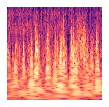

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

side_px=256
dpi=150
plot = plt.figure(figsize=(side_px/dpi, side_px/dpi))

CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(librosa.istft(D_percussive), sr=sr)), ref=np.max)
p=librosa.display.specshow(CQT,x_axis=None,y_axis=None)
plt.axis('off')

The image is actually a matplotlib figure. The predict function of the fastai learner expects to be given a tensor to work with. Could be that the conversion had been easier if the spectrogram was saved out to a file first and then loaded from disk. The idea is to deploy the model later on a web server and it's best to avoid unnecessary disk access for temporary files.

In [ ]:
type(plot)

matplotlib.figure.Figure

A little googling turned up a short tutorial on turning a figure into a PIL RGBA image. The idea being that the PIL image could then be converted to a tensor. The original URL in the comment below is now broken but as luck would have it the wayback machine has a snapshot of it [here](https://web.archive.org/web/20200712151644/http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure).

In [ ]:
#collapse-output
!pip install Pillow

In [ ]:
# http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

In [ ]:
from PIL import Image as pil_Image

# http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return pil_Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

Converting the figure to an image

In [ ]:
im = fig2img(plot)

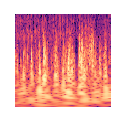

In [ ]:
im

and turning the image into a tensor.

In [ ]:
from PIL import ImageMath

im_float = ImageMath.eval("convert(a,'F')", a=im)
im_tensor = pil2tensor(im_float, np.float32)


In [ ]:
im_fastai = Image(px=im_tensor)

### Predicting the state of the engine

Finally the tensor can be given to fastai. The model seems to think that the engine runs normally.

In [ ]:
pred_class,pred_idx,outputs = learn.predict(im_fastai)
pred_class

Category normal